In [2]:
import logging
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
from math import pow , sqrt, atan2
import math
import pywt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(color_codes=True)
from sklearn.manifold import LocallyLinearEmbedding
from sklearn import manifold, datasets
from scipy.signal import argrelextrema
from scipy.spatial.distance import pdist
from scipy.stats.mstats import pearsonr, spearmanr
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import procrustes

In [5]:
#take the dataset from the preprocess

df = pd.read_pickle('df.pickle')
feats = ['Age','Education','Nscore','Escore','Oscore','Ascore','Cscore','Impulsive','SS']

#Normalization of the data
df_feature = df.loc[:, feats].values
scaler =StandardScaler()
scaler.fit(df_feature)
df_feature = scaler.transform(df_feature)

df_label = df.loc[:,['Heroin']].values
Lab = pd.DataFrame(data = df_label, columns = ['Heroin'])

In [6]:
df

,Age,Education,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS,Heroin,F,M
ID,,,,,,,,,,,,
1,3,6,39,36,42,37,42,-0.21712,-1.18084,0,1,0
2,2,9,29,52,55,48,41,-0.71126,-0.21575,0,0,1
3,3,6,31,45,40,32,34,-1.37983,0.40148,0,0,1
4,1,8,34,34,46,47,46,-1.37983,-1.18084,0,1,0
5,3,9,43,28,43,41,50,-0.21712,-0.21575,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1884,1,5,25,51,57,48,33,0.88113,1.92173,0,1,0
1885,1,5,33,51,50,48,30,0.88113,0.76540,0,0,1
1886,2,7,47,30,37,31,31,0.52975,-0.52593,0,1,0


# Some information about data
all in panda dataframe
size( 1856,12)

1) Lab:
    it's two columns with the output  (size :
    
2) df_feature :
    it's the input normalized
    
    



# Function

In [7]:
# find best number of neighbor
def num_neigh(Data,dim, meth):
    Pears = []
    N_Neigh_Max = 100
    NCOMP       = dim
    if meth == "standard":
        nmin = NCOMP+1
        Vect_N      = np.arange(nmin,N_Neigh_Max,1)
    if meth == "hessian":
        nmin =round(NCOMP*(NCOMP+3)/2)+2
        Vect_N      = np.arange( nmin,N_Neigh_Max,1)
    Tot_Err     = []
    for i in Vect_N:
        _, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method=meth,eigen_solver="dense")
        Tot_Err.append(err)
    Tot_err = np.array(Tot_Err)
    indices = argrelextrema(Tot_err, np.less)

    if len(indices) < 2:
        best_Ns = np.arange(nmin,nmin*2,1)

    else:
        best_Nspanda = pd.DataFrame(Vect_N[indices])
        best_Ns = (Vect_N[indices])
    for i in best_Ns:
        DataTransfo, err = manifold.locally_linear_embedding(Data, n_neighbors=i,n_components=NCOMP,method = meth,eigen_solver="dense")
        Dx = pdist(DataTransfo, 'euclidean')
        Dy = pdist(Data, 'euclidean')
        Pear, _= pearsonr(Dx, Dy)
        Pears.append(Pear)
    best_N = best_Ns[Pears.index(min(Pears))]
    return best_N,Pears



In [8]:
# find best knn neigbor
def knn(Data_feature,Data_label, Kmax):
    Vect_K      = np.arange(1,Kmax,1)
    Accs =[]
    for i in Vect_K:
        #Create KNN Classifier
        knn = KNeighborsClassifier(n_neighbors=i)
        
        Data_train = Data_feature[:1200]
        Data_test = Data_feature[1200:]
        Data_test_label = Data_label[1200:]
        Data_train_label = Data_label[:1200]
        #Train the model using the training sets
        knn.fit(Data_train,Data_train_label.ravel())

        #Predict the response for test dataset
        y_pred = knn.predict(Data_test)
    
        Accs.append(metrics.accuracy_score(Data_test_label, y_pred))
    Kopt = Vect_K[Accs.index(max(Accs))]
    return Kopt
        

In [9]:
# criterion for the dimensionality redcution : Spearman's Rho

def SpearmR(Data_original,Data_transfo):
    NNeigh = 15
    neigh = NearestNeighbors(n_neighbors=NNeigh)
    
    neigh.fit(Data_original)
    dist_original = neigh.kneighbors(Data_original)
    
    neigh.fit(Data_transfo)
    dist_transfo = neigh.kneighbors(Data_transfo)
    
    Rho = spearmanr(dist_original,dist_transfo,axis = None)
    return np.mean(Rho)
    

In [10]:
# criterion for the dimensionality redcution : Classification Rate
def classifR(Data_original_feature,Data_transfo_feature,label,K):
   
    #Create KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=K)
    
    lab_train = label[:1200]
    lab_test = label[1200:]
    
    # for original data
    Data_original_train = Data_original_feature[:1200]
    Data_original_test = Data_original_feature[1200:]
    
    #Train the model using the training sets
    knn.fit(Data_original_train,lab_train.ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_original_test)

    Acc_original = metrics.accuracy_score(lab_test, y_pred)
    
    Data_transfo_train = Data_transfo_feature[:1200]
    Data_transfo_test = Data_transfo_feature[1200:]

    #Train the model using the training sets
    knn.fit(Data_transfo_train,lab_train.ravel())

    #Predict the response for test dataset
    y_pred = knn.predict(Data_transfo_test)

    Acc_transfo = metrics.accuracy_score(lab_test, y_pred)
    
    ClassR = (Acc_original -Acc_transfo)/Acc_original
    
    return ClassR
        

# Visualization
For 2 Dimensions and 3 dimensions

In [11]:
# pca 2 dimensions
pca = PCA(n_components=2)
Data_pca =pca.fit_transform(df_feature)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

principalDf = pd.DataFrame(data = Data_pca
             , columns = ['PrComp 1', 'PrComp 2',]) 
pca_Df = pd.concat([principalDf, Lab], axis = 1)



[0.2743579  0.20636121]
[68.22376239 59.1685557 ]


In [16]:
Lab.info

<bound method DataFrame.info of       Heroin
0          0
1          0
2          0
3          0
4          0
...      ...
1880       0
1881       0
1882       0
1883       0
1884       0

[1885 rows x 1 columns]>

In [10]:
# LLE : 2 dimensions

# find best number of neighbor
NN_LLE,Pearcoef= num_neigh(df_feature,2, "standard")
# do the LLE
LLE_results, LLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_LLE,n_components=2,eigen_solver="dense")

# conver to panda data frame with index and comportement
LLE_Df_feature = pd.DataFrame(data = LLE_results, columns = ['LLE 1', 'LLE 2'])
LLE_Df = pd.concat([LLE_Df_feature, Lab], axis = 1)
print(NN_LLE)

8


In [11]:
# LLE : 3 dimensions

# find best number of neighbor
NN_LLE,Pearcoef= num_neigh(df_feature,3, "standard")
# do the LLE
LLE_results_3d, LLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_LLE,n_components=3)

# conver to panda data frame with index and comportement
LLE_Df_feature_3d = pd.DataFrame(data = LLE_results_3d, columns = ['LLE 1', 'LLE 2','LLE 3'])
LLE_Df_3d = pd.concat([LLE_Df_feature_3d, Lab], axis = 1)

print(NN_LLE)

8


In [23]:
# HLLE : 2 dimensions
NN_HLLE,Pearcoeff= num_neigh(df_feature,2, "hessian")
#NN_HLLE = 20
HLLE_results, HLLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_HLLE,n_components=2,method="hessian",eigen_solver="dense")

# conver to panda data frame with index and comportement
HLLE_Df_feature = pd.DataFrame(data = HLLE_results, columns = ['HLLE 1', 'HLLE 2'])
HLLE_Df = pd.concat([HLLE_Df_feature, Lab], axis = 1)
print(NN_HLLE)

45


In [15]:
# HLLE : 3 dimensions

# find best number of neighbor
NN_HLLE,Pearcoef= num_neigh(df_feature,3, "hessian")
# do the LLE
HLLE_results_3d, HLLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_HLLE,n_components=3, method = "hessian",eigen_solver="dense")

# conver to panda data frame with index and comportement
HLLE_Df_feature_3d = pd.DataFrame(data = HLLE_results_3d, columns = ['HLLE 1', 'HLLE 2','HLLE 3'])
HLLE_Df_3d = pd.concat([HLLE_Df_feature_3d, Lab], axis = 1)
print(NN_HLLE)


49


# Plot


## Plot 2D

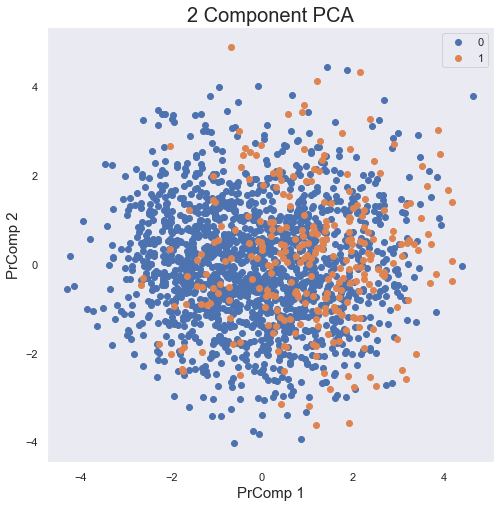

In [12]:
#plot for pca
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PrComp 1', fontsize = 15)
ax.set_ylabel('PrComp 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [0,1]
colors = ['r', 'g', 'b',"m"]
for target, color in zip(targets,colors):
    indicesToKeep = pca_Df['Heroin'] == target
    ax.scatter(pca_Df.loc[indicesToKeep, 'PrComp 1']
               , pca_Df.loc[indicesToKeep, 'PrComp 2'])

ax.legend(targets)
ax.grid()

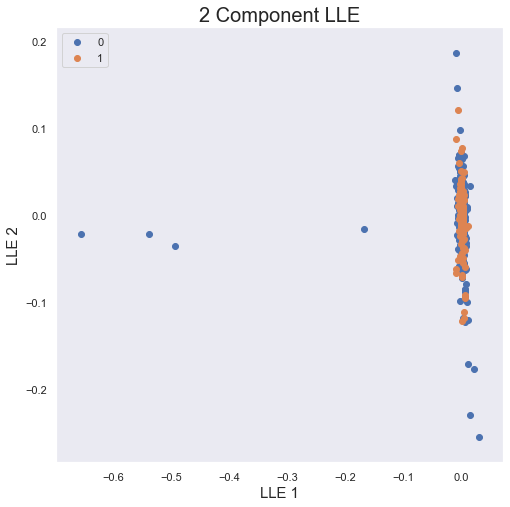

In [16]:
#plot for LLe
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('LLE 1', fontsize = 15)
ax.set_ylabel('LLE 2', fontsize = 15)
ax.set_title('2 Component LLE', fontsize = 20)

targets = [0,1]
colors = ['r', 'g', 'b',"m"]
for target, color in zip(targets,colors):
    indicesToKeep = LLE_Df['Heroin'] == target
    ax.scatter(LLE_Df.loc[indicesToKeep, 'LLE 1']
               , LLE_Df.loc[indicesToKeep, 'LLE 2'])

ax.legend(targets)
ax.grid()

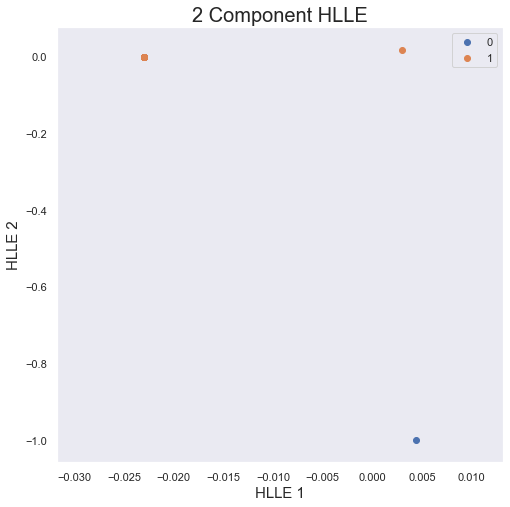

In [24]:
#plot for HLLe
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('HLLE 1', fontsize = 15)
ax.set_ylabel('HLLE 2', fontsize = 15)
ax.set_title('2 Component HLLE', fontsize = 20)

targets = [0,1]
colors = ['r', 'g', 'b',"m"]
for target, color in zip(targets,colors):
    indicesToKeep = HLLE_Df['Heroin'] == target
    ax.scatter(HLLE_Df.loc[indicesToKeep, 'HLLE 1']
               , HLLE_Df.loc[indicesToKeep, 'HLLE 2'])

ax.legend(targets)
ax.grid()

## Plot 3d

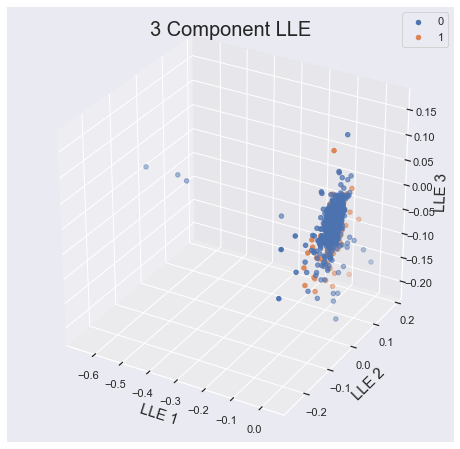

In [19]:
# plot 3d LLE
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('LLE 1', fontsize = 15)
ax.set_ylabel('LLE 2', fontsize = 15)
ax.set_zlabel('LLE 3', fontsize = 15)
ax.set_title('3 Component LLE', fontsize = 20)

targets = [0,1]
colors = ['r', 'g', 'b',"m"]
for target, color in zip(targets,colors):
    indicesToKeep = LLE_Df_3d['Heroin'] == target
    ax.scatter(LLE_Df_3d.loc[indicesToKeep, 'LLE 1']
               , LLE_Df_3d.loc[indicesToKeep, 'LLE 2'], LLE_Df_3d.loc[indicesToKeep, 'LLE 3'])

ax.legend(targets)
ax.grid()

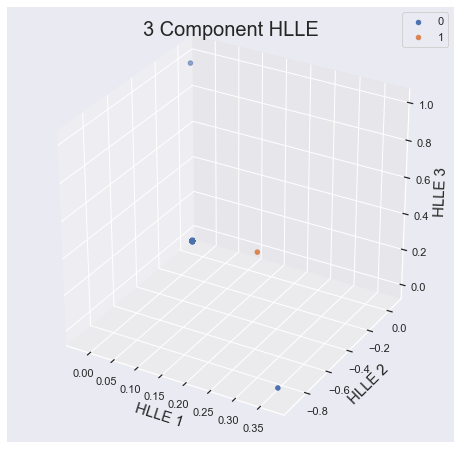

In [20]:
# plot 3d HLLE

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111,projection='3d') 
ax.set_xlabel('HLLE 1', fontsize = 15)
ax.set_ylabel('HLLE 2', fontsize = 15)
ax.set_zlabel('HLLE 3', fontsize = 15)
ax.set_title('3 Component HLLE', fontsize = 20)

targets = [0,1]
colors = ['r', 'g', 'b',"m"]
for target, color in zip(targets,colors):
    indicesToKeep = HLLE_Df_3d['Heroin'] == target
    ax.scatter(HLLE_Df_3d.loc[indicesToKeep, 'HLLE 1']
               , HLLE_Df_3d.loc[indicesToKeep, 'HLLE 2'], HLLE_Df_3d.loc[indicesToKeep, 'HLLE 3'])

ax.legend(targets)
ax.grid()

## Comparison for  visualization
With Classification rate

In [39]:
# PCA
kopt_pca = knn(principalDf,Lab.values, 40)
r_pca = classifR(df_feature,principalDf,Lab.values,kopt_pca)

# LLE
kopt_LLE = knn(LLE_Df_feature,Lab.values, 40)
r_LLE = classifR(df_feature,LLE_Df_feature,Lab.values,kopt_LLE)

# HLLE
kopt_HLLE = knn(HLLE_Df_feature,Lab.values, 40)
r_HLLE = classifR(df_feature,HLLE_Df_feature,Lab.values,kopt_HLLE)
print("classification rate for pca  is",r_pca," for LLE is" , r_LLE," and for HLLE is", r_HLLE)

classification rate for pca  is -0.0016977928692698695  for LLE is -0.006814310051107265  and for HLLE is 0.0


# Dimensionality reduction
with two different criterions : classification rate and sparman's rho

In [106]:
#find the best dim for reduction for LLE
dmax = 12
spearm_LLE = []
preoc_LLE =[]
classif_LLE = []

for d in np.arange(1,dmax-2,1):
    # find best number of neighbor
    NN_LLE,Pearcoef= num_neigh(df_feature,int(d), "standard")
    # do the LLE
    LLE_results, LLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_LLE,n_components=d)
    
    
    # value for classification rate
    k = knn(LLE_results,Lab.values, 40)
    classif_LLE.append(classifR(df_feature,LLE_results,Lab.values,k))
    
    # spearman rho
    spearm_LLE.append(SpearmR(df_feature,LLE_results))
    
    # procrustre 
    #preoc.append(procrustes(df_feature, LLE_results))


    

[0.4066603819919169]
[0.4066603819919169, 0.40514632485220237]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211, 0.40843385160214696]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211, 0.40843385160214696, 0.4207689099765625]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211, 0.40843385160214696, 0.4207689099765625, 0.4255477432463762]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211, 0.40843385160214696, 0.4207689099765625, 0.4255477432463762, 0.4320137101562702]
[0.4066603819919169, 0.40514632485220237, 0.4064441770418737, 0.4086135641654211, 0.40843385160214696, 0.4207689099765625, 0.4255477432463762, 0.4320137101562702, 0.4324281779787287]


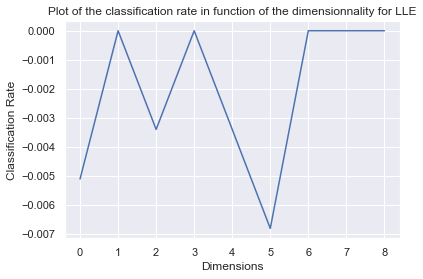

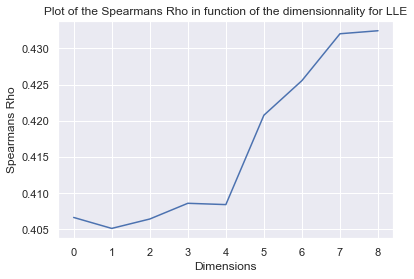

In [113]:
plt.figure("figure1")
plt.title( "Plot of the classification rate in function of the dimensionnality for LLE")
plt.xlabel("Dimensions")
plt.ylabel("Classification Rate")
plt.plot (classif_LLE)
plt.savefig('plotLLEclass.png')
plt.figure("figure2")
plt.title( "Plot of the Spearmans Rho in function of the dimensionnality for LLE")
plt.xlabel("Dimensions")
plt.ylabel("Spearmans Rho")
plt.plot (spearm_LLE)
plt.savefig('plotLLEspear.png')

In [ ]:
classif_LLE

In [ ]:
spearm_LLE

In [108]:
#find the best dim for reduction for HLLE
dmax = 12
spearm = []
preoc =[]
classif = []

for d in np.arange(1,dmax-2,1):
    # find best number of neighbor
    NN_HLLE,Pearcoef= num_neigh(df_feature,int(d), "hessian")
    # do the LLE
    HLLE_results, HLLE_err = manifold.locally_linear_embedding(df_feature, n_neighbors=NN_HLLE,n_components=d)
    
    # value for classification rate
    k = knn(HLLE_results,Lab.values, 40)
    classif.append(classifR(df_feature,HLLE_results,Lab.values,k))
    
    # spearman rho
    spearm.append(SpearmR(df_feature,HLLE_results))
    
    # procrustre 
    #preoc.append(procrustes(df_feature, LLE_results, scaling=True, reflection='best'))


    

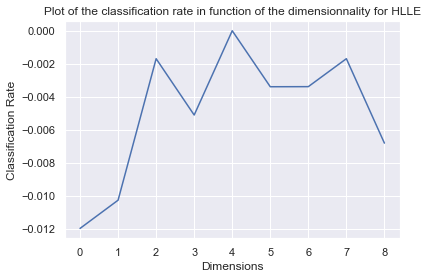

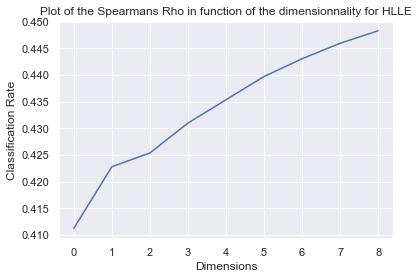

In [110]:
plt.figure("figure1")
plt.title( "Plot of the classification rate in function of the dimensionnality for HLLE")
plt.xlabel("Dimensions")
plt.ylabel("Classification Rate")
plt.plot(classif)     
plt.savefig('plotHLLEclass.png')
plt.figure("figure2")
plt.title( "Plot of the Spearmans Rho in function of the dimensionnality for HLLE")
plt.xlabel("Dimensions")
plt.ylabel("Classification Rate")
plt.plot (spearm)
plt.savefig('plotHLLEspear.png')


In [111]:
classif

[-0.011986301369862973,
 -0.010273972602739635,
 -0.0016949152542373377,
 -0.0051107325383303835,
 0.0,
 -0.003395585738539868,
 -0.0033898305084746755,
 -0.0016949152542373377,
 -0.006814310051107265]

In [112]:
spearm

[0.4112460348660158,
 0.422807767143634,
 0.42539848409317954,
 0.4309923927336383,
 0.4353674443584622,
 0.43972131339173903,
 0.4430584416196106,
 0.4459558045228768,
 0.44830911078621194]